In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM

from recommenders import MainRecommender

J:\Vadim\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
from lightfm.evaluation import precision_at_k, recall_at_k

from metrics import precision_at_k as custom_precision, recall_at_k
from utils import prefilter_items

In [3]:
data = pd.read_csv('C:/Users/Вадим/Desktop/GeekBrains/Recommendation-systems/Lectures/Lecture_2/webinar_2/webinar_2'
                   '/data/retail_train.csv')

item_features = pd.read_csv('C:/Users/Вадим/Desktop/GeekBrains/Recommendation-systems/Lectures/Lecture_2/webinar_2/webinar_2'
                            '/data/product.csv')
user_features = pd.read_csv('C:/Users/Вадим/Desktop/GeekBrains/Recommendation-systems/Lectures/Lecture_2/webinar_2/webinar_2'
                            '/data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [5]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [6]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [7]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [8]:
user_features['marital_status_code'].unique()

array(['A', 'U', 'B'], dtype=object)

In [9]:
user_features['household_size_desc'].unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

## 1. Filter items

In [10]:
n_items_before = data_train['item_id'].nunique()

In [11]:
data_train_filtered = prefilter_items(data_train, take_n_popular=5000, item_features=item_features)

C:\Users\Вадим\Documents\My Notebooks\Recommenders System\utils.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / data['quantity']


In [12]:
n_items_after = data_train_filtered['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 86865 to 5001


# 2. Prepare data set

## 2.1 Prepare csr train matrix

In [13]:
user_item_matrix = pd.pivot_table(data_train_filtered,
                                  index='user_id', columns='item_id',
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count',
                                  fill_value=0
                                  )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,117847,818981,819255,819308,819400,819487,819590,819594,819840,819845,...,15926775,15926844,15926886,15972074,15972298,15972565,15972790,16100266,16729299,16729415
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.2 Prepare CSR test matrix

In [14]:
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]

test_user_item_matrix = pd.pivot_table(data_test,
                                       index='user_id', columns='item_id',
                                       values='quantity', # Можно пробоват ьдругие варианты
                                       aggfunc='count',
                                       fill_value=0
                                       )

test_user_item_matrix = test_user_item_matrix.astype(float) # необходимый тип матрицы для implicit

In [15]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

## 3. Prepare user and item features

In [16]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)
user_feat.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
user_feat.shape

(2497, 7)

In [18]:
item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)
item_feat.head(2)

,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
item_id,,,,,,
117847,450.0,NUTRITION,National,REFRIGERATED,SOY/RICE MILK,64 OZ
818981,194.0,GROCERY,National,COLD CEREAL,ALL FAMILY CEREAL,10.4 OZ


In [19]:
item_feat.shape

(5001, 6)

## Encoding features

In [20]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [21]:
user_feat_lightfm.head(2)

,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_code_A,marital_status_code_B,marital_status_code_U,income_desc_100-124K,...,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
item_feat_lightfm.head(2)

,manufacturer_2.0,manufacturer_5.0,manufacturer_16.0,manufacturer_20.0,manufacturer_26.0,manufacturer_33.0,manufacturer_35.0,manufacturer_36.0,manufacturer_42.0,manufacturer_43.0,...,curr_size_of_product_L 16 OZ,curr_size_of_product_L 7.75 OZ,curr_size_of_product_L 13.25 OZ,curr_size_of_product_LB,curr_size_of_product_N 12 OZ,curr_size_of_product_N 40 OZ,curr_size_of_product_PINT,curr_size_of_product_PK,curr_size_of_product_PT,curr_size_of_product_QT
item_id,,,,,,,,,,,,,,,,,,,,,
117847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
818981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Init model

In [23]:
model = LightFM(no_components=128,
                loss='bpr', # "logistic","bpr", "warp"
                learning_rate=0.01,
                item_alpha=0.1,
                user_alpha=0.1,
                random_state=42,
                k=5,
                n=15,
                max_sampled=100)

## Train

In [24]:
model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=20,
          num_threads=20,
          verbose=True)

Epoch: 100%|██████████| 20/20 [13:07<00:00, 39.35s/it]


# Getting embeddings

## вектора по пользователям

In [26]:
user_emb = model.get_user_representations(features=csr_matrix(user_feat_lightfm.values).tocsr())

In [27]:
user_emb[0].shape # biases

(2497,)

In [28]:
user_emb[1].shape # users vectors

(2497, 128)

## вектора по товарам

In [29]:
item_emb = model.get_item_representations(features=csr_matrix(item_feat_lightfm.values).tocsr())

In [30]:
item_emb[0].shape # biases

(5001,)

In [31]:
item_emb[1].shape # items vectors

(5001, 128)

# Evaluation -> Train precision

In [32]:
# мы можем использовать встроенные метрики lightFM

train_precision = precision_at_k(model, sparse_user_item,
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

print(f"Train precision {train_precision}")

Train precision 0.4385262429714203


# Predict

In [33]:
# подготавливаемм id для юзеров и товаров в порядке пар user-item
users_ids_row = data_train_filtered['user_id'].apply(lambda x: userid_to_id[x]).values.astype(int)
items_ids_row = data_train_filtered['item_id'].apply(lambda x: itemid_to_id[x]).values.astype(int)

In [34]:
users_ids_row

array([2371, 1363, 1363, ..., 1167,  461,  461])

In [35]:
items_ids_row

array([2959, 2040, 2040, ..., 2040, 4636, 4808])

In [36]:
# модель возвращает меру/скор похожести между соответствующим пользователем и товаром
predictions = model.predict(user_ids=users_ids_row,
                            item_ids=items_ids_row,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                            num_threads=20)

#### добавляем наш полученный скор в трейн датафрейм

In [ ]:
data_train_filtered['score'] = predictions

In [38]:
data_train_filtered.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price,score
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0,2.99,-0.615264
11,1364,26984896261,1,999999,1,2.19,31742,0.00,1520,1,0.0,0.0,2.19,-2.780948
12,1364,26984896261,1,999999,1,2.99,31742,-0.40,1520,1,0.0,0.0,2.99,-2.780948
13,1364,26984896261,1,999999,1,3.09,31742,0.00,1520,1,0.0,0.0,3.09,-2.780948
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,2.50,-3.307335


#### создаем предикт датафрейм в формате списка товаров

In [39]:
predict_result = data_train_filtered[['user_id','item_id','score']][data_train_filtered.item_id != 999999].drop_duplicates().sort_values(by=['user_id','score'], ascending=False).groupby('user_id')['item_id'].unique().reset_index()

In [40]:
predict_result.head()

,user_id,item_id
0,1,"[1029743, 6034857, 1088462, 838867, 7431408, 7..."
1,2,"[1106523, 1075368, 899624, 952163, 6919458, 96..."
2,3,"[1106523, 983584, 5585510, 899624, 866211, 112..."
3,4,"[1029743, 1075368, 1052294, 7431408, 970760, 1..."
4,5,"[1126899, 1029743, 6034991, 825659, 1112387, 1..."


#### объединяем предикт и тест датасет для подсчета precision

In [41]:
df_result_for_metrics = result.merge(predict_result, on='user_id', how='inner')

In [42]:
df_result_for_metrics.head()

,user_id,actual,item_id
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1029743, 6034857, 1088462, 838867, 7431408, 7..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 983584, 5585510, 899624, 866211, 112..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1070820, 1029743, 1126899, 1121393, 9524291, ..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1029743, 1126899, 1106523, 9835880, 1072494, ..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1106523, 1070820, 1029743, 6034857, 5585510, ..."


### Test with custom precision func

In [43]:
precision = df_result_for_metrics.apply(lambda row: custom_precision(row['item_id'], row['actual'],k=5), axis=1).mean()
print(f"Precision: {precision}")

Precision: 0.14436781609195212


#### Запустим модель меняя входные параметры для поиска наилучших метрик

In [ ]:
import itertools

l1 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
l2 = np.linspace(0.01, 0.09, 9, endpoint=True)
loss = ['bpr', 'warp']  # 'logistic',
params = list(itertools.product(l1, l2, loss, repeat=1))

In [ ]:
result_dict = {}
i = 0
for no_components, item_alpha, loss in params:
    model = LightFM(no_components=no_components,
                    loss=loss,  # "logistic","bpr", "warp"
                    learning_rate=0.01,
                    item_alpha=item_alpha,
                    user_alpha=0.1,
                    random_state=42,
                    k=5,
                    n=15,
                    max_sampled=100)

    model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
              sample_weight=coo_matrix(user_item_matrix),
              user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
              item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
              epochs=20,
              num_threads=20,
              verbose=True)

    predictions = model.predict(user_ids=users_ids_row,
                                item_ids=items_ids_row,
                                user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                num_threads=10)

    data_train_filtered['score'] = predictions

    # создаем предикт датафрейм в формате списка товаров
    predict_result = data_train_filtered[['user_id', 'item_id', 'score']][
        data_train_filtered.item_id != 999999].drop_duplicates().sort_values(by=['user_id', 'score'],
                                                                             ascending=False).groupby('user_id')[
        'item_id'].unique().reset_index()
    # объединяем предикт и тест датасет для подсчета precision
    df_result_for_metrics = result.merge(predict_result, on='user_id', how='inner')
    precision = df_result_for_metrics.apply(lambda row: custom_precision(row['item_id'], row['actual'], k=5),
                                            axis=1).mean()
    print(f"Precision: {precision}")
    iteration_tuple = (("no_components", no_components),
                       ("loss", loss),
                       ("item_alpha", item_alpha),
                       ("precision", precision))
    result_dict[str(i)] = dict(iteration_tuple)
    i += 1


#### Получим следующие результаты (частично)

'0' = {dict: 4} {'no_components': 10, 'loss': 'bpr', 'item_alpha': 0.01, 'precision': 0.15550082101806242}
'1' = {dict: 4} {'no_components': 10, 'loss': 'warp', 'item_alpha': 0.01, 'precision': 0.14062397372742202}
'2' = {dict: 4} {'no_components': 10, 'loss': 'bpr', 'item_alpha': 0.02, 'precision': 0.15215106732348113}
'3' = {dict: 4} {'no_components': 10, 'loss': 'warp', 'item_alpha': 0.02, 'precision': 0.13983579638752053}
'4' = {dict: 4} {'no_components': 10, 'loss': 'bpr', 'item_alpha': 0.03, 'precision': 0.15264367816091953}
'5' = {dict: 4} {'no_components': 10, 'loss': 'warp', 'item_alpha': 0.03, 'precision': 0.13766830870279148}
'6' = {dict: 4} {'no_components': 10, 'loss': 'bpr', 'item_alpha': 0.04, 'precision': 0.149688013136289}
'7' = {dict: 4} {'no_components': 10, 'loss': 'warp', 'item_alpha': 0.04, 'precision': 0.1360919540229885}
'8' = {dict: 4} {'no_components': 10, 'loss': 'bpr', 'item_alpha': 0.05, 'precision': 0.1485057471264368}
'9' = {dict: 4} {'no_components': 10, 'loss': 'warp', 'item_alpha': 0.05, 'precision': 0.13648604269293924}
'10' = {dict: 4} {'no_components': 10, 'loss': 'bpr', 'item_alpha': 0.060000000000000005, 'precision': 0.14752052545155994}
'11' = {dict: 4} {'no_components': 10, 'loss': 'warp', 'item_alpha': 0.060000000000000005, 'precision': 0.11569786535303778}
'12' = {dict: 4} {'no_components': 10, 'loss': 'bpr', 'item_alpha': 0.06999999999999999, 'precision': 0.14545155993431855}
'13' = {dict: 4} {'no_components': 10, 'loss': 'warp', 'item_alpha': 0.06999999999999999, 'precision': 0.10367816091954023}
'14' = {dict: 4} {'no_components': 10, 'loss': 'bpr', 'item_alpha': 0.08, 'precision': 0.14574712643678162}
'15' = {dict: 4} {'no_components': 10, 'loss': 'warp', 'item_alpha': 0.08, 'precision': 0.10151067323481117}
'16' = {dict: 4} {'no_components': 10, 'loss': 'bpr', 'item_alpha': 0.09, 'precision': 0.14564860426929394}
'17' = {dict: 4} {'no_components': 10, 'loss': 'warp', 'item_alpha': 0.09, 'precision': 0.07983579638752053}
'18' = {dict: 4} {'no_components': 20, 'loss': 'bpr', 'item_alpha': 0.01, 'precision': 0.15372742200328407}
'19' = {dict: 4} {'no_components': 20, 'loss': 'warp', 'item_alpha': 0.01, 'precision': 0.14082101806239739}
'20' = {dict: 4} {'no_components': 20, 'loss': 'bpr', 'item_alpha': 0.02, 'precision': 0.15087027914614123}
'21' = {dict: 4} {'no_components': 20, 'loss': 'warp', 'item_alpha': 0.02, 'precision': 0.1393431855500821}
'22' = {dict: 4} {'no_components': 20, 'loss': 'bpr', 'item_alpha': 0.03, 'precision': 0.15057471264367814}
'23' = {dict: 4} {'no_components': 20, 'loss': 'warp', 'item_alpha': 0.03, 'precision': 0.13668308702791462}
'24' = {dict: 4} {'no_components': 20, 'loss': 'bpr', 'item_alpha': 0.04, 'precision': 0.1485057471264368}
'25' = {dict: 4} {'no_components': 20, 'loss': 'warp', 'item_alpha': 0.04, 'precision': 0.12535303776683088}
'26' = {dict: 4} {'no_components': 20, 'loss': 'bpr', 'item_alpha': 0.05, 'precision': 0.14830870279146144}
'27' = {dict: 4} {'no_components': 20, 'loss': 'warp', 'item_alpha': 0.05, 'precision': 0.10614121510673234}
'28' = {dict: 4} {'no_components': 20, 'loss': 'bpr', 'item_alpha': 0.060000000000000005, 'precision': 0.14663382594417076}
'29' = {dict: 4} {'no_components': 20, 'loss': 'warp', 'item_alpha': 0.060000000000000005, 'precision': 0.10052545155993432}
'30' = {dict: 4} {'no_components': 20, 'loss': 'bpr', 'item_alpha': 0.06999999999999999, 'precision': 0.14584564860426932}
'31' = {dict: 4} {'no_components': 20, 'loss': 'warp', 'item_alpha': 0.06999999999999999, 'precision': 0.09648604269293924}
'32' = {dict: 4} {'no_components': 20, 'loss': 'bpr', 'item_alpha': 0.08, 'precision': 0.14515599343185548}
'33' = {dict: 4} {'no_components': 20, 'loss': 'warp', 'item_alpha': 0.08, 'precision': 0.08052545155993432}
'34' = {dict: 4} {'no_components': 20, 'loss': 'bpr', 'item_alpha': 0.09, 'precision': 0.14486042692939247}
'35' = {dict: 4} {'no_components': 20, 'loss': 'warp', 'item_alpha': 0.09, 'precision': 0.07589490968801313}
'36' = {dict: 4} {'no_components': 30, 'loss': 'bpr', 'item_alpha': 0.01, 'precision': 0.1528407224958949}
'37' = {dict: 4} {'no_components': 30, 'loss': 'warp', 'item_alpha': 0.01, 'precision': 0.14170771756978653}
'38' = {dict: 4} {'no_components': 30, 'loss': 'bpr', 'item_alpha': 0.02, 'precision': 0.15067323481116585}
'39' = {dict: 4} {'no_components': 30, 'loss': 'warp', 'item_alpha': 0.02, 'precision': 0.1386535303776683}
'40' = {dict: 4} {'no_components': 30, 'loss': 'bpr', 'item_alpha': 0.03, 'precision': 0.14791461412151066}
'41' = {dict: 4} {'no_components': 30, 'loss': 'warp', 'item_alpha': 0.03, 'precision': 0.13717569786535305}
'42' = {dict: 4} {'no_components': 30, 'loss': 'bpr', 'item_alpha': 0.04, 'precision': 0.1472249589490969}
'43' = {dict: 4} {'no_components': 30, 'loss': 'warp', 'item_alpha': 0.04, 'precision': 0.10929392446633826}
'44' = {dict: 4} {'no_components': 30, 'loss': 'bpr', 'item_alpha': 0.05, 'precision': 0.14614121510673234}
'45' = {dict: 4} {'no_components': 30, 'loss': 'warp', 'item_alpha': 0.05, 'precision': 0.10042692939244664}
'46' = {dict: 4} {'no_components': 30, 'loss': 'bpr', 'item_alpha': 0.060000000000000005, 'precision': 0.14545155993431855}
'47' = {dict: 4} {'no_components': 30, 'loss': 'warp', 'item_alpha': 0.060000000000000005, 'precision': 0.09776683087027915}
'48' = {dict: 4} {'no_components': 30, 'loss': 'bpr', 'item_alpha': 0.06999999999999999, 'precision': 0.1452545155993432}
'49' = {dict: 4} {'no_components': 30, 'loss': 'warp', 'item_alpha': 0.06999999999999999, 'precision': 0.08407224958949097}
'50' = {dict: 4} {'no_components': 30, 'loss': 'bpr', 'item_alpha': 0.08, 'precision': 0.14417077175697865}
'51' = {dict: 4} {'no_components': 30, 'loss': 'warp', 'item_alpha': 0.08, 'precision': 0.07796387520525452}
'52' = {dict: 4} {'no_components': 30, 'loss': 'bpr', 'item_alpha': 0.09, 'precision': 0.144367816091954}
'53' = {dict: 4} {'no_components': 30, 'loss': 'warp', 'item_alpha': 0.09, 'precision': 0.07540229885057471}
'54' = {dict: 4} {'no_components': 40, 'loss': 'bpr', 'item_alpha': 0.01, 'precision': 0.15530377668308704}
'55' = {dict: 4} {'no_components': 40, 'loss': 'warp', 'item_alpha': 0.01, 'precision': 0.1401313628899836}
'56' = {dict: 4} {'no_components': 40, 'loss': 'bpr', 'item_alpha': 0.02, 'precision': 0.15323481116584567}
'57' = {dict: 4} {'no_components': 40, 'loss': 'warp', 'item_alpha': 0.02, 'precision': 0.13530377668308702}
'58' = {dict: 4} {'no_components': 40, 'loss': 'bpr', 'item_alpha': 0.03, 'precision': 0.14929392446633827}
'59' = {dict: 4} {'no_components': 40, 'loss': 'warp', 'item_alpha': 0.03, 'precision': 0.1289983579638752}
'60' = {dict: 4} {'no_components': 40, 'loss': 'bpr', 'item_alpha': 0.04, 'precision': 0.14722495894909687}
'61' = {dict: 4} {'no_components': 40, 'loss': 'warp', 'item_alpha': 0.04, 'precision': 0.10446633825944171}
'62' = {dict: 4} {'no_components': 40, 'loss': 'bpr', 'item_alpha': 0.05, 'precision': 0.14732348111658458}
'63' = {dict: 4} {'no_components': 40, 'loss': 'warp', 'item_alpha': 0.05, 'precision': 0.09944170771756979}
'64' = {dict: 4} {'no_components': 40, 'loss': 'bpr', 'item_alpha': 0.060000000000000005, 'precision': 0.14604269293924468}
'65' = {dict: 4} {'no_components': 40, 'loss': 'warp', 'item_alpha': 0.060000000000000005, 'precision': 0.09077175697865353}
'66' = {dict: 4} {'no_components': 40, 'loss': 'bpr', 'item_alpha': 0.06999999999999999, 'precision': 0.14633825944170772}
'67' = {dict: 4} {'no_components': 40, 'loss': 'warp', 'item_alpha': 0.06999999999999999, 'precision': 0.07796387520525451}
'68' = {dict: 4} {'no_components': 40, 'loss': 'bpr', 'item_alpha': 0.08, 'precision': 0.14505747126436783}
'69' = {dict: 4} {'no_components': 40, 'loss': 'warp', 'item_alpha': 0.08, 'precision': 0.07530377668308703}
'70' = {dict: 4} {'no_components': 40, 'loss': 'bpr', 'item_alpha': 0.09, 'precision': 0.14377668308702793}
'71' = {dict: 4} {'no_components': 40, 'loss': 'warp', 'item_alpha': 0.09, 'precision': 0.07471264367816091}
'72' = {dict: 4} {'no_components': 50, 'loss': 'bpr', 'item_alpha': 0.01, 'precision': 0.15215106732348113}
'73' = {dict: 4} {'no_components': 50, 'loss': 'warp', 'item_alpha': 0.01, 'precision': 0.14101806239737275}
'74' = {dict: 4} {'no_components': 50, 'loss': 'bpr', 'item_alpha': 0.02, 'precision': 0.15244663382594417}
'75' = {dict: 4} {'no_components': 50, 'loss': 'warp', 'item_alpha': 0.02, 'precision': 0.13756978653530377}
'76' = {dict: 4} {'no_components': 50, 'loss': 'bpr', 'item_alpha': 0.03, 'precision': 0.15096880131362891}

In [45]:
pr_1 = [0.1555,0.1521,0.1526,0.1496,0.1485,0.1475,0.1454,0.1457,0.1456]
pr_2 = [0.1537,0.1508,0.1505,0.1485,0.1483,0.1466,0.1458,0.1451,0.1448]
pr_3 = [0.1528,0.1506,0.1479,0.1472,0.1461,0.1454,0.1452,0.1441,0.1443]
pr_4 = [0.1553,0.1532,0.1492,0.1472,0.1473,0.1460,0.1463,0.1450,0.1437]

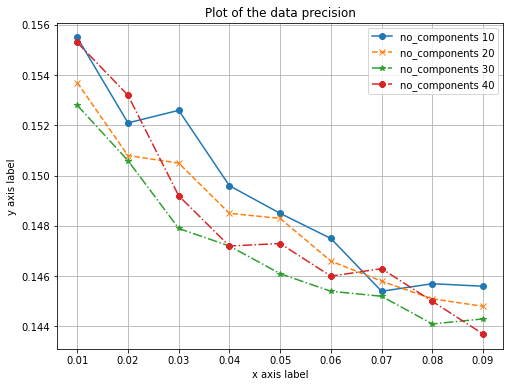

In [65]:
xticks = [0.01*i for i in range(1,10)]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(xticks, pr_1, "o-")
ax.plot(xticks, pr_2, "x--")
ax.plot(xticks, pr_3, "*-.")
ax.plot(xticks, pr_4, "8-.")
ax.grid()
ax.set_title("Plot of the data precision")
ax.set_xlabel("x axis label")
ax.set_ylabel("y axis label")
ax.legend(("no_components 10", "no_components 20", "no_components 30", "no_components 40"))
